In this Jupyter notebook we showcase evolutionary IB-LGCA, i.e. we look at proliferating cells, where daughter cells inherit properties of mother cells plus a noise term. This idea is applied to two different models of cell proliferation and invasion and key aspects are highlighted with the help of computer simulations.

# Proof of principle: *"Go-and-grow"*
A simple model to apply this idea is a birth-death process coupled to a random walk, sometimes referred to as *"go-and-grow"* system. 
In every time step, each cell $i$ has an individual probability $\alpha_i$ of proliferating and a constant probability $\delta$ of dying. If the cell proliferates, the daughter cell $j$ will have a new proliferation probability $\alpha_j$, which is normally distributed random variable, whose mean is equal to the proliferation probability of the mother cell $i$
$$ \alpha_j \sim \mathcal{N}(\alpha_i, \sigma^2),$$
where the variance $\sigma^2$ is a parameter of the model.

After proliferation, each cell performs a random walk.

It is known that the classical "go-and-grow"-model without evolutionary dynamics, can be approximated by Fisher's equation,
$$ \partial_t \rho = D \partial_{xx} \rho + \alpha \rho (1 - \rho),$$
where $\rho (x, t)$ is the cell density, $D$ is the diffusion constant and $\alpha$ is the reproduction rate. This equation has travelling wave solutions with wavespeeds $c \geq 2\sqrt{\alpha D}$. Clearly the wave speed grows with the reproduction rate. 
**Therefore, if due to evolutionary processes the reproduction rate increases, we will observe an increasing invasion speed.**

So let's have a look at computer simulations of the model.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from lgca import get_lgca

In [ ]:
l = 100
tmax = 200
restchannels = 2
n_channels = restchannels + 2
nodes = np.zeros((l, n_channels), dtype=bool)
nodes[0] = 1

lgca = get_lgca(ib=True, nodes=nodes, bc='reflect', interaction='birthdeath', geometry='lin', r_b=.2, r_d=0.01, std=0.05)
lgca.timeevo(timesteps=tmax, record=True)

We use a one-dimensional IB-LGCA with $a = 2$ rest channels and lattice size $L = 100$ and reflecting boundary conditions. As a initial condition, we use an empty lattice except for the left-most node, which is filled completely. We record the time evolution for 100 time steps and look at the resulting density profile.

In [ ]:
lgca.plot_density(cmap='magma')

We observe that the invasion speed increases with time. Next, we can look at the distribution of the mean proliferation probability $\alpha (r, k)$.

In [ ]:
lgca.plot_prop_spatial(cmap='cividis')
#plt.savefig('gng_alpha.png', dpi=600)

In [ ]:
lgca.plot_flux()

We see that over time "niches" of faster proliferating cells appear.

Finally, let's have a look at the population mean of the proliferation probability.

In [ ]:
lgca.plot_prop_timecourse()
plt.ylabel('$\\alpha$')
#plt.savefig('gng_mean_alpha.png', dpi=600)

Clearly, due to stochastic fluctuations and "neutral evolution", it increases over time. It will reach a plateau at $\alpha \approx 1$.

In [ ]:
alpha = lgca.get_prop()
plt.plot(alpha.mean(-1))

# A more complicated case: *"Go-or-grow"*
In a more complicated example, we can look at the "go-or-grow" system. In this model, only cells in rest channels can proliferate with the constant probability $r_b$, all cells die with probability $r_d$, and cells switch from rest channels to velocity channels with a probability $r_s$ that depends on the local density $\rho(r) = \frac{n(r)}{K}$, where $n(r)$ is the cell number at node $r$ and $K$ is the carrying capacity $K = a + b$,
$$ r_s (\rho) =  \frac{1}{2} [1 + \tanh  (\kappa (\rho - \theta)) ].$$
The probability to switch back, from velocity to rest channels, is given by $1 - r_s(\rho)$. $\kappa$ and $\theta$ are parameters of the model; $\kappa$ determines, if the switch probability increases or decreases with density and $\theta$ is a threshold, where the slope of $r_s$ is maximal.

In the evolutionary approach, we make the parameter $\kappa$ indivual for each cell $i$, $\kappa^{(i)}$, and as in the example before, daughter cells $j$ inherit the parameter from mother cells $j$ as
$$ \kappa^{(j)} \sim \mathcal{N}(\kappa^{(i)}, \sigma^2),$$
where the strength of the noise $\sigma^2$ is another parameter of the model.

To showcase properties of the model, we use a one-dimensional LGCA with reflecting boundary conditions again.

In [ ]:
l = 25
restchannels = 2
K = restchannels + 2
tmax = 100
nodes = np.ones((l, K))
# nodes[0] = 1

lgca2 = get_lgca(ib=True, geometry='lin', bc='reflect', interaction='go_or_grow', r_d=0.01, nodes=nodes, kappa=0)
lgca2.timeevo(timesteps=tmax, record=True)

In [ ]:
lgca2.plot_prop_spatial()

We see that even though the population with $\kappa < 0$ is expected to always persist, while it may die out for $\kappa > 0$. There is an evolutionary pressure to the regime $\kappa > 0$ if the lattice is fully occupied.

# Research questions
There are many open questions that can be investigated within the framework of evolutionary LGCA. They include, but are not restricted to:

1. Is it possible to analytically predict the time evolution of the evolutionary cell properties?
2. Can we analytically predict spatial distributions of the evolutionary cell property? Can we relate this to biological data?
3. How is the relation between the (spatial or non-spatial) Moran models for tumor progression?
4. Are there biological applications of the model, i.e. systems where the time scales of evolution and migration are not totally separated?

## Some thoughts on the mathematical analysis
Consider the logistic growth model with evolutionary dynamics in the non-spatial case (one node) with capacity $K$. Then the number of particles with fitness $\alpha$ is given by 
\begin{equation}
n(\alpha, k) = \sum_i s_i(k) \delta( \alpha, \alpha_i(k)),
\end{equation}
while the total number of particles is 
$$n(k) = \int \mathrm{d}\alpha \, n(\alpha, k) = \sum_i s_i(k).$$
The channel $i$ develops in discrete time steps as
$$s_i(k+1) = s_i(k) - \mu_i(k) s_i(k) + (1 - s_i(k)) \sum_j^{K-1} \nu_{ij}(k) \xi_j(k) s_j(k) \prod_{l=0}^{j-1}\left(1- \nu_{il}(k)\xi_l(k) s_l(k)\right), $$
where $\mu_i, \xi_j, \nu_{ij}$ are Boolean stochastic variables controlling death, birth an destination of daughter cell respectively, with probabilities
\begin{align}
P(\mu_i(k) = 1) &= r_d \\
P(\xi_i(k) = 1| \alpha_i) &= \alpha_i, \\
P(\nu_{ij}(k) = 1) &= \frac{1}{K}.
\end{align}
During a proliferation event the daughter's proliferation rate is determined as 
$$ \alpha_i'(k) = \alpha_j(k) + \beta_j(k),$$
where $\beta_i(k)$ is a Gaussian distributed stochastic variable with variance $\sigma^2$
$$P(\beta) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp \left( - \frac{\beta^2}{2 \sigma^2} \right).$$
We want to derive a mean-field theory. So let's introduce the mean number of cells with fitness $\alpha$ as
$$\rho (\alpha, k) := \sum_i s_i P(\mathbf{s}, \alpha, k) = \left\langle n(\alpha, k) \right\rangle.$$
Computing the expected value under a mean-field approximation and summing over channels $i$ we obtain
$$ \rho(\alpha, k+1) = \rho(\alpha, k) - r_d \rho(\alpha, k) + (1 - \varrho(k)) \int \mathrm{d}\beta \, \alpha' \rho(\alpha', k) P(\beta = \alpha - \alpha') = \\
=\rho(\alpha, k) - r_d \rho(\alpha, k) + (1 - \varrho(k)) \underbrace{\int \mathrm{d}\beta \,(\alpha - \beta) \rho(\alpha - \beta, k) P(\beta)}_{(\alpha \rho(\alpha)) \ast P(\alpha)}.$$
If the variance during proliferation is small, i.e. $\sigma^2 \ll 1$, only those values $\beta$ close to zero will add to the integral and we can approximate the density by its Taylor approximation, $\rho(\alpha - \beta) \approx \rho(\alpha) - \beta \rho'(\alpha) + \frac{\beta^2}{2} \rho''(\alpha)$. The integral can then be carried out analytically (note that $P(\beta)$ is an even function and that $\int P(\beta) = 1$)
$$\int \mathrm{d}\beta \, \left( \alpha \rho(\alpha) - \beta \rho(\alpha) - \alpha \beta \rho'(\alpha) + \beta^2 \rho'(\alpha) + \alpha \beta^2/2 \rho''(\alpha) - \beta^3/2 \rho''(\alpha) \right) P(\beta) = \\
= \alpha \rho(\alpha) + \sigma^2 \rho'(\alpha) + \alpha \sigma^2 / 2 \rho''(\alpha) = \alpha \rho(\alpha) + \frac{\sigma^2}{2} \partial^2_\alpha (\alpha \rho(\alpha)).$$

In [ ]:
%matplotlib inline

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lgca import get_lgca
from scipy.integrate import odeint, solve_ivp
from scipy.ndimage.filters import laplace
from scipy.special import erf
from math import sqrt

In [ ]:
def gaussian(x):
    y = np.exp(-0.5 * x**2) / sqrt(2 * np.pi)
    return y

def cdf_gaussian(x):
    y = 0.5 * (1 + erf(x / sqrt(2)))
    return y

def trunc_gaussian(x, mu, sigma, a=0, b=1):
    xi = (x - mu) / sigma
    beta = (b - mu) / sigma
    alpha = (a - mu) / sigma
    y = gaussian(xi) / sigma
    y /= cdf_gaussian(beta) - cdf_gaussian(alpha)
    return y
    

def dydt_int(t, y, alpha, r_d, var, a_min, a_max):
    dalpha = alpha[1]-alpha[0]
#     rho = y.sum() * dalpha
    rho = np.trapz(y, dx=dalpha)
    dy = np.empty_like(y)
    for i, a in enumerate(alpha):
        dy[i] = np.trapz(alpha * y * trunc_gaussian(a - alpha, 0., sqrt(var), a=a_min-alpha, b=a_max-alpha), dx=dalpha)
    
#     dy = alpha * y + var * np.gradient(y, dalpha) + 0.5 * alpha * var * laplace(y) / dalpha**2
    dy *= 1 - rho
    dy -= r_d * y
    return dy


def dydt(t, y, alpha, r_d, var):
    dalpha = alpha[1]-alpha[0]
    rho = np.trapz(y, dx=dalpha)
    dy = alpha * y + var * np.gradient(y, dalpha) + 0.5 * alpha * var * laplace(y) / dalpha**2
    dy[0] = alpha[0] * y[0] + alpha[0] * var * (y[1] - y[0]) / dalpha**2
    dy[-1] = alpha[-1] * y[-1] + alpha[-1] * var * (y[-2] - y[-1]) / dalpha**2
    dy *= 1 - rho
    dy -= r_d * y
    return dy

def dydt_int2(t, y, alpha, r_d, var, a_min, a_max):  # without fixed volume similar to experiment
    dalpha = alpha[1]-alpha[0]
#     rho = y.sum() * dalpha
    rho = np.trapz(y, dx=dalpha)
    dy = np.empty_like(y)
    for i, a in enumerate(alpha):
        dy[i] = np.trapz(alpha * y * trunc_gaussian(a - alpha, 0., sqrt(var), a=a_min-alpha, b=a_max-alpha), dx=dalpha)
    
#     dy = alpha * y + var * np.gradient(y, dalpha) + 0.5 * alpha * var * laplace(y) / dalpha**2
    # dy *= 1 - rho
    dy -= r_d * y
    return dy


def dydt2(t, y, alpha, r_d, var):  # without volume restriction as in experiment
    dalpha = alpha[1]-alpha[0]
    rho = np.trapz(y, dx=dalpha)
    dy = alpha * y + var * np.gradient(y, dalpha) + 0.5 * alpha * var * laplace(y) / dalpha**2
    dy[0] = alpha[0] * y[0] + alpha[0] * var * (y[1] - y[0]) / dalpha**2
    dy[-1] = alpha[-1] * y[-1] + alpha[-1] * var * (y[-2] - y[-1]) / dalpha**2
    # dy *= 1 - rho
    dy -= r_d * y
    return dy


In [ ]:
a_max = 1.
alpha, dalpha = np.linspace(0, a_max, num=201, retstep=True)
r_d = 0.02
r_b = 0.1
var = 0.05**2
tmax = 1000
dens0 = 1
ts = np.linspace(0, tmax, num=51)
y0 = np.zeros_like(alpha)
y0[np.argwhere(alpha==r_b)] = dens0 / dalpha
sol = odeint(dydt_int2, y0, ts, args=(alpha, r_d, var, 0., a_max), tfirst=True)
sol2 = odeint(dydt2, y0, ts, args=(alpha, r_d, var), tfirst=True)

In [ ]:
for t in np.arange(len(ts))[5::10]:
    p = plt.plot(alpha, sol[t], label='t = {:n}'.format(ts[t]))
    plt.plot(alpha, sol2[t], '--', label='_t = {:n}'.format(ts[t]), color=p[0].get_color())

#plt.plot(alpha, sol[-1], label='t = {:n}'.format(ts[-1]))
plt.xlabel('$\\alpha$')
plt.ylabel('$\\rho(\\alpha)$')
plt.legend()
#plt.savefig('rho_alpha.png', dpi=600)

In [ ]:
lgca = get_lgca(ib=True, density=dens0, bc='reflect', interaction='birthdeath', std=sqrt(var),
                r_d=r_d, r_b=r_b, a_max=a_max, geometry='1d', dims=1, restchannels=10000)
lgca.timeevo(timesteps=tmax, record=True)

In [ ]:
# lgca.plot_prop_timecourse()
# plt.plot(ts, np.trapz(sol.y * alpha, dx=dalpha) / np.trapz(sol.y, dx=dalpha), label='Integral MF')
plt.plot(ts, (sol2 * alpha).sum(-1) / sol2.sum(-1), label='Local MF')
plt.title('')
plt.ylabel('$\\langle\\alpha\\rangle$')
plt.legend()
#plt.savefig('mean_alpha.png', dpi=600)

In [ ]:
plt.plot(np.arange(len(lgca.dens_t)), lgca.dens_t/lgca.K)
plt.plot(ts, sol.sum(-1) * dalpha, label='Integral MF')
plt.plot(ts, sol2.sum(-1) * dalpha, label='Local MF')

plt.title('')
plt.ylabel('$\\rho$')
plt.legend()
#plt.savefig('mean_alpha.png', dpi=600)

In [ ]:
bins = int(np.ceil(np.log2(lgca.occupied.sum()))+1)
plt.hist(np.array(lgca.props['r_b'])[lgca.nodes[lgca.nodes > 0]], bins=bins, density=True, label='LGCA')
plt.plot(alpha, sol[-1] / sol[-1].sum() / dalpha, label='Int MF')
plt.plot(alpha, sol2[-1] / sol2[-1].sum() / dalpha, label='Local MF')
plt.xlabel('$\\alpha$')
plt.ylabel('$\\rho(\\alpha, t \\to \\infty)$')
plt.legend()
#plt.savefig('rho_alpha_steady_comparison.png', dpi=600)

## Simplification: Discrete evolution
Similarly as before, we can imagine a system, where mutations only change the fitness by a predefined small $\Delta \alpha$. Then, cells can only assume discrete proliferation rates $\alpha_i \in \{ \bar\alpha, \bar\alpha \pm \Delta \alpha, \dots \}$, where $\bar\alpha$ is the initial fitness value, which we assume to be the same for every initial cell, for simplicity.

Let us look at an example realization of this model in LGCA.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from lgca import get_lgca

In [ ]:
l = 100
tmax = 300
restchannels = 8
n_channels = restchannels + 2
nodes = np.zeros((l, n_channels), dtype=bool)
nodes[0] = 1

lgca = get_lgca(ib=True, nodes=nodes, bc='reflect', interaction='birthdeath_discrete',
                geometry='lin', r_b=.1, r_d=0.01, drb=0.05)
lgca.timeevo(timesteps=tmax, record=True)

In [ ]:
lgca.plot_density(cmap='magma')

In [ ]:
lgca.plot_prop_spatial(cmap='cividis')

In [ ]:
lgca.plot_prop_timecourse()
plt.ylabel('$\\alpha$')

### Mathematical analysis
Consider the logistic growth model with evolutionary dynamics in the non-spatial case (one node) with capacity $K$. We denote the occupancy of channel $j$ by $s_{j, k}$, and the unique label of a cell in channel $j$ is $\sigma_{j, k} \in \mathbb{N}_0$, where $\sigma_{j, k} = 0$ denotes an empty channel. The set $ \mathcal{A} = \{\alpha_\min, \alpha_\min + \Delta \alpha, \dots, \alpha_\max \}$ denotes all possible fitness values in the discrete system, and the sequence $(\alpha_oi \in \mathcal{A})_{i \in \mathbb{N}}$ refers to the fitness values of all cells $i$. Then the number of particles with fitness $\tilde\alpha \in \mathcal{A}$ at time $k$ is given by 
$$
n_{k}(\tilde\alpha) = \sum_j \delta_{\tilde\alpha, \alpha_{\sigma_{j, k}}},
$$
where  $\delta_{\alpha_i, \alpha_j}$ is a generelized Kronecker symbol,
$$
\delta_{\alpha_i, \alpha_j} = \begin{cases}1 & \text{if}\, \alpha_i =\alpha_j, \\
0 & \text{else}.
\end{cases}
$$
while the total number of particles is 
$$n(k) = \sum_\alpha n_{k}(\alpha) = \sum_j s_j(k).$$
The channel $i$ develops in discrete time steps as
$$s_{i, k+1} = s_{i, k} - \mu_{i, k} s_{i, k} + (1 - s_{i, k}) \sum_j^{K-1} \nu_{ij, k} \xi_{j, k} s_{j, k}, $$
where $\mu_{i, k}, \xi_{i, k}, \nu_{ij, k}$ are Boolean stochastic variables controlling death, birth and placement of daughter cell respectively, with probabilities
\begin{align}
P(\mu_{i, k} = 1) &= r_d \\
P(\xi_{i, k} = 1) &= \alpha_{\sigma_{i,k}}, \\
P(\nu_{ij, k} = 1) &= \frac{1}{K}, \\
\sum_{j = 0}^{K-1} \nu_{ij, k} &= 1.
\end{align}
During a proliferation event the daughter cell is assigned a unique label $d$ and its proliferation rate depends on the mother cell $m$. If there is no mutation event, the daughter's proliferation rate is equal to the mother's $\alpha_d = \alpha_m$; however, with a small probability $p_m$ the daughter mutates, and its proliferation rate decreases or increases by $\Delta \alpha$ compared to the mother.

We want to derive a mean-field theory. So let's introduce the mean number of cells with fitness $\alpha$ as
$$\rho_k (\alpha) := \sum_i s_i P(\mathbf{s}, \alpha, k) = \left\langle n(\alpha, k) \right\rangle.$$
Computing the expected value under a mean-field approximation and summing over channels $i$ we obtain
$$ \rho(\alpha, k+1) = \rho(\alpha, k) - r_d \rho(\alpha, k) + (1 - \varrho(k)) \left[ (\alpha - \Delta \alpha) \frac{p_m}{2} \rho(\alpha - \Delta \alpha, k) + (\alpha + \Delta \alpha) \frac{p_m}{2} \rho(\alpha + \Delta\alpha, k) + (1 - p_m) \alpha \rho (\alpha, k) \right],$$
where $\varrho(k) := \left\langle n(k) \right\rangle$.

I now want to investigate the regime where the fitness advantage gained through mutations is small $\Delta \alpha \to 0$. I also introduce a small time step length $\tau$ and continuous time $t = k \tau$. Then, after expanding into Taylor series and keeping only the leading terms of order $\tau^2, \Delta \alpha^2$, I obtain

$$ \tau \partial_t \rho + \frac{\tau^2}{2} \partial^2_t \rho= -r_d \rho + (1 - \varrho) \left[ \alpha \rho + \frac{p_m}{2}\Delta \alpha^2 \partial^2_{\alpha} (\alpha \rho) \right]$$

I can further simplify this by introducing the rates
\begin{align}
r_d' &:= \frac{r_d}{\tau},\\
\alpha' &:= \frac{\alpha}{\tau}.
\end{align}
To obtain
$$\partial^2_t \rho + \frac{2}{\tau} \partial_t \rho = \frac{2}{\tau} \left[ -r'_d \rho + (1 - \varrho) \alpha' \rho \right] + (1 - \varrho) p_m\frac{\Delta \alpha'^2}{\tau} \partial^2_{\alpha'} (\alpha' \rho)$$
Finally, I define the "mutation constant"
$$ D_\alpha := \lim_{\tau, \Delta \alpha \to 0} \frac{p_m \Delta \alpha'^2}{\tau}. $$
After dropping the primes for better readability, we end up with the PDE
$$ \partial^2_t \rho + \frac{2}{\tau} \partial_t \rho = \frac{2}{\tau} \left[ -r_d \rho + (1 - \varrho) \alpha \rho \right] + (1 - \varrho) D_\alpha \partial^2_{\alpha} (\alpha \rho).$$
This PDE contains two time scales: the short time scale of births and deaths, $\tau$, and the long time scale of mutations.

Note: The derivation using the second-order time scale is probably wrong!

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lgca import get_lgca
from scipy.integrate import solve_ivp
from scipy.ndimage.filters import laplace, convolve1d
import seaborn as sns

In [ ]:
# first order approximation
def dydt(t, y, alpha, r_d, v):
    da = alpha[1] - alpha[0]
    rho = np.trapz(y, dx=da)
    alpharho = alpha * y
    dy = alpharho + v * laplace(alpharho)
    dy *= 1 - rho
    dy -= r_d * y
    return dy


# second order approximation
def dydt2(t, y, alpha, r_d, D, tau):
    i = len(y) // 2
    da = alpha[1] - alpha[0]
    dy = np.empty_like(y)
    dy[:i] = y[i:]
    rho = y[:i]
    varrho = np.trapz(rho, dx=da)
    alpharho = alpha * rho
    dy[i:] = alpharho / tau + D * laplace(alpharho)
    dy[i:] *= 1 - varrho
    dy[i:] -= r_d * rho / tau
    dy[i:] -= y[i:] / tau
    dy[i:] *= 2
    return dy

def dydt_wave(t, y, alpha, r_d, D):
    i = len(y) // 2
    da = alpha[1] - alpha[0]
    dy = np.empty_like(y)
    dy[:i] = y[i:]
    rho = y[:i]
    varrho = np.trapz(rho, dx=da)
    alpharho = alpha * rho
    meanalpha = np.trapz(alpharho, dx=da) / varrho
    dy[i:] = D * laplace(alpharho) * r_d / meanalpha
#     dy[i:] *= 1 - varrho
    dy[i:] *= 2
    return dy

In [ ]:
a_max = 1.
dalpha = 0.005
na = 101
alpha, da = np.linspace(0, a_max, num=na, retstep=True, endpoint=True)
r_b = 0.1
r_d = 0.03
tau = 1
p_m = 1
v = p_m * (dalpha / da)**2 / 2
tmax = 10000
dens0 = 1 - r_d / r_b
print(dens0)
ts = np.linspace(0, tmax, num=101)

In [ ]:
y0 = np.zeros_like(alpha)
y0[np.argwhere(alpha==r_b)] = dens0 / da
sol = solve_ivp(dydt, (0, tmax), y0, t_eval=ts, args=(alpha, r_d, v), method='Radau', vectorized=False, max_step=.1,
                rtol=1e-4, atol=1e-7)

In [ ]:
# D = p_m * (dalpha / da) ** 2 / 2
# y02 = np.hstack([y0, np.zeros_like(y0)])
# sol2 = solve_ivp(dydt2, (0, tmax), y02, t_eval=ts, args=(alpha, r_d, D, tau), method='Radau', vectorized=False, max_step=.1,
#                  rtol=1e-4)
# sol2.y = sol2.y[:na]

In [ ]:
# sol3 = solve_ivp(dydt_wave, (0, tmax), y02, t_eval=ts, args=(alpha, r_d, D), vectorized=False, method='Radau', max_step=.1,
#                  rtol=1e-4)
# sol3.y = sol3.y[:na]

In [ ]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2

In [76]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2

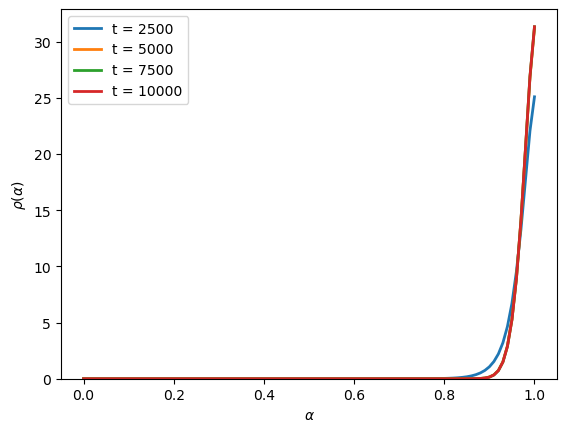

In [77]:
for t in np.linspace(0, len(sol.t)-1, num=5, dtype=int)[1:]:
    pl = plt.plot(alpha, sol.y[:, t], label='t = {:n}'.format(sol.t[t]))
#     plt.plot(alpha, sol2.y[:, t], '--', c=pl[0].get_color())
#     plt.plot(alpha, sol3.y[:, t], '-.', c=pl[0].get_color())

#plt.plot(alpha, sol[-1], label='t = {:n}'.format(ts[-1]))
plt.xlabel('$\\alpha$')
plt.ylabel('$\\rho(\\alpha)$')
plt.ylim(0)
plt.legend()
#plt.savefig('rho_alpha.png', dpi=600)

In [78]:
lgca = get_lgca(ib=True, density=dens0, bc='reflect', interaction='birthdeath', pmut=p_m, drb=dalpha, std=dalpha,
                r_d=r_d, r_b=r_b, a_max=a_max, geometry='1d', dims=1, restchannels=2000)
lgca.pm = p_m
lgca.timeevo(timesteps=tmax, record=True)

Family relationships not tracked.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [08:37<00:00, 19.32it/s]


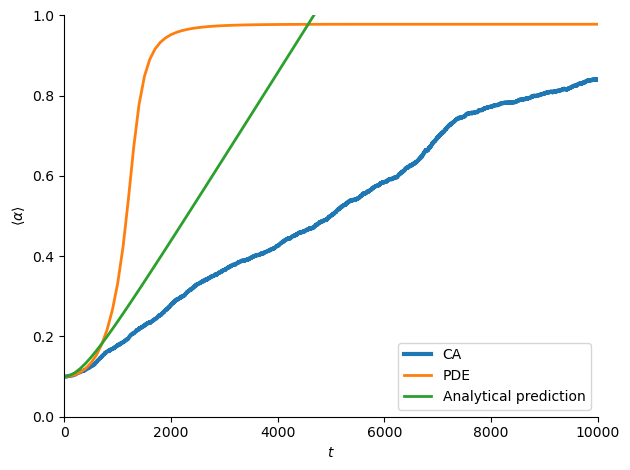

In [92]:
lgca.plot_prop_timecourse(label='CA', lw=lw)
# plt.plot(alphalgca, label='LGCA')
# plt.plot(solmf.t, solmf.y[1])
# plt.plot(ts, np.trapz(sol2.y * alpha[..., None], axis=0, dx=da) / np.trapz(sol2.y, axis=0, dx=da), label='MF2')
# plt.plot(ts, np.trapz(sol3.y * alpha[..., None], axis=0, dx=da) / np.trapz(sol3.y, axis=0, dx=da), label='MF3')
# plt.plot(ts, np.sqrt(2 * r_d**2 * dalpha**2 * ts**2 + 2 * dalpha**2 * ts + r_b**2))
plt.plot(ts, np.trapz(sol.y * alpha[..., None], axis=0, dx=da) / np.trapz(sol.y, axis=0, dx=da), label='PDE')
plt.plot(ts, meanfitness(ts, r_b, r_d, p_m*dalpha**2, 0), label='Analytical prediction')
plt.ylim(0, 1)
plt.xlim(0, tmax)
plt.title('')
plt.ylabel('$\\langle\\alpha\\rangle$')
plt.legend()
sns.despine()
plt.tight_layout()
# plt.savefig('mean_alpha.svg', dpi=600)

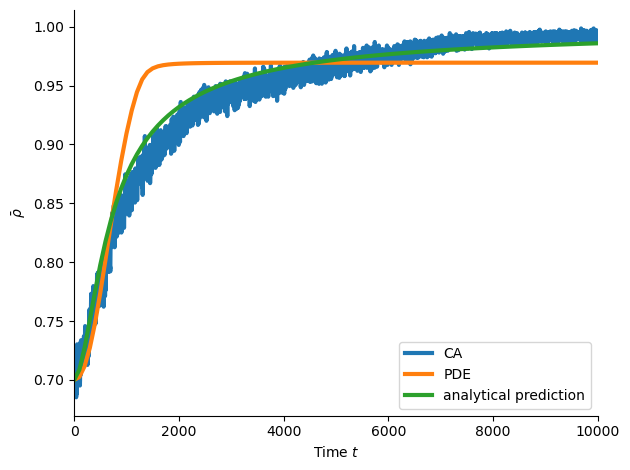

In [91]:
plt.plot(np.arange(tmax+1), lgca.dens_t/lgca.K, label='CA', lw=lw)
plt.plot(ts, np.trapz(sol.y, axis=0, dx=da), label='PDE', lw=lw)
plt.plot(ts, 1 - r_d / meanfitness(ts, r_b, r_d, p_m*dalpha**2, 0), label='analytical prediction', lw=lw)
# plt.plot(ts, np.trapz(sol2.y, axis=0, dx=da), label='MF2')
# plt.plot(solmf.t, solmf.y[0])
plt.ylabel('$\\bar{\\rho}$')
plt.xlabel('Time $t$')
plt.xlim(0, tmax)
plt.legend()
sns.despine()
plt.tight_layout()
# plt.savefig('density.svg', dpi=600)

In [90]:
# analytical predictions for bulk
def meanfitness(t, r_b, r_d, m, v0):
    """
    mean fitness over time in the bulk, given initial mean birth rate r_b, initial variance v0, mutationrate m
    """
    return np.sqrt(2 * r_d**2 * m * t**2 + 2 * r_d * (v0+m) * t + r_b**2)

In [ ]:
fig, ax = plt.subplots(ncols=2)
meanalpha = np.trapz(sol.y * alpha[..., None], axis=0, dx=da) / np.trapz(sol.y, axis=0, dx=da)
varalpha = np.trapz(sol.y * alpha[..., None]**2, axis=0, dx=da) / np.trapz(sol.y, axis=0, dx=da) - meanalpha**2
plt.sca(ax[0])
# lgca.plot_prop_timecourse(label='CA')
# plt.plot(alphalgca, label='LGCA')
plt.plot(ts, meanalpha, label='PDE')
plt.plot(ts, meanfitness(ts, r_b, r_d, p_m*dalpha**2, 0), label='Analytical prediction')
# plt.plot(solmf.t, solmf.y[1])
# plt.plot(ts, np.trapz(sol2.y * alpha[..., None], axis=0, dx=da) / np.trapz(sol2.y, axis=0, dx=da), label='MF2')
# plt.plot(ts, np.trapz(sol3.y * alpha[..., None], axis=0, dx=da) / np.trapz(sol3.y, axis=0, dx=da), label='MF3')
# plt.plot(ts, np.sqrt(2 * r_d**2 * dalpha**2 * ts**2 + 2 * dalpha**2 * ts + r_b**2))
plt.xlim(0, tmax)
plt.title('')
plt.ylabel('$\\langle\\alpha\\rangle$')
plt.legend()
plt.sca(ax[1])
plt.plot(ts, varalpha, label='PDE', lw=lw)
plt.plot(ts, r_d * dalpha**2 * p_m * ts)
plt.xlim(0, 100)

sns.despine()

In [ ]:
props = np.array(lgca.props['r_b'])[lgca.nodes[lgca.nodes > 0]]
bins = np.arange(0, a_max+dalpha/2, dalpha) - dalpha/2
plt.hist(props, density=True, label='CA')
plt.plot(alpha, sol.y[:, -1] / sol.y[:, -1].sum() / da, label='PDE', lw=lw)
# plt.plot(alpha, sol2.y[:, -1] / sol2.y[:, -1].sum() / da, label='MF2')
# plt.xlabel('$\\alpha$')
plt.ylabel('$\\rho(\\alpha, t \\to \\infty)$')
plt.legend()

In [ ]:
from scipy.stats import norm

def normaldist(x, m, var, z):
    f = norm.cdf(x, loc=m, scale=np.sqrt(var))
    return (1 - f) * z

def dalphadt(t, y, r_d, var, amax):
    r, m, s = y
    dr = r * m * (1 - r) - r_d * r
    dm = (1 - r) * (s + var )
    ds = (1 - r) * (2 * var * m)
    return (dr, dm, ds)

In [ ]:
var = dalpha ** 2
solmf = solve_ivp(dalphadt, (0, tmax), (dens0, r_b, 0), t_eval=ts, args=(r_d, var, a_max), method='LSODA')

In [ ]:
plt.plot(solmf.t, solmf.y[2])

In [ ]:
%matplotlib inline
plt.rcParams['svg.fonttype'] = 'none'
sns.set_style('white')
sns.set_palette('colorblind')

In [ ]:
l = 50
tmax = 100
restchannels = 1
n_channels = restchannels + 2
nodes = np.zeros((l, n_channels), dtype=bool)
nodes[:3] = 1

lgca = get_lgca(ib=True, nodes=nodes, bc='reflect', interaction='birthdeath', 
                geometry='lin', std=0.15,
                r_d=0.05, r_b=r_b, a_max=a_max)
lgca.pm = p_m
lgca.timeevo(timesteps=tmax, record=True)

In [ ]:
lgca.plot_density(cmap='magma', colorbarwidth=0.3)
# plt.plot([0, l-1], [0, tmax], 'r--', lw=3, label='$c_{\max}$')
# plt.legend()
plt.xlabel('Node $r$')
plt.ylabel('Time $k$')
plt.gca().yaxis.set_ticks_position('left')
# plt.savefig('density.svg')

In [ ]:
lgca.plot_prop_spatial(cmap='viridis')#, cbarlabel=r'Mean proliferation rate $\left\langle \alpha \right\rangle$')
plt.xlabel('Node $r$')
plt.ylabel('')
plt.gca().yaxis.set_ticks([])
# plt.savefig('alpha.svg')

In [ ]:
def dydt_spatial(t, y, alpha, dx, r_d, v):
    y = y.reshape((-1, len(alpha)))
    da = alpha[1] - alpha[0]
    rho = np.trapz(y, dx=da, axis=-1)
    alpharho = alpha * y
    dy = alpharho + v * convolve1d(alpharho, [1, -2, 1], axis=-1)
    dy += (1 - rho[..., None]) * y
    dy -= r_d * y
    dy += convolve1d(y, [1, -2, 1], axis=0) / dx**2 / 2
    return dy.flatten()

In [ ]:
nx = 101
x, dx = np.linspace(0, 100, nx, retstep=True, endpoint=True)
a_max = 1.
dalpha = 0.05
na = 101
alpha, da = np.linspace(0, a_max, num=na, retstep=True, endpoint=True)
r_b = 0.1
r_d = 0.03
p_m = .1
v = p_m * (dalpha / da)**2 / 2
tmax = 100
# dens0 = 1 - r_d / r_b
dens0 = 0.01
ts = np.linspace(0, tmax, num=11)

In [ ]:
y0 = np.zeros((nx, na))
y0[0, np.argwhere(alpha==r_b)] = dens0 / da
sol = solve_ivp(dydt_spatial, (0, tmax), y0.flatten(), t_eval=ts, args=(alpha, dx, r_d, v), vectorized=False)#, rtol=1e-4, atol=1e-6)

In [ ]:
sol

In [ ]:
y = sol.y.reshape((nx, na, len(sol.t)))
rhotot = np.trapz(y, dx=da, axis=1)
meanalpha = np.divide(np.trapz(alpha[..., None, None] * y, dx=da, axis=1), rhotot, where=rhotot>0, out=np.zeros_like(rhotot))

In [ ]:
plt.plot(x, rhotot[:, 1])

In [ ]:
y0.sum() * dalpha * dx

In [ ]:
for t in np.linspace(0, len(sol.t)-1, num=5, dtype=int)[1:]:
    pl = plt.plot(alpha, sol.y[:, t], label='t = {:n}'.format(sol.t[t]), lw=lw)
#     plt.plot(alpha, sol2.y[:, t], '--', c=pl[0].get_color())
#     plt.plot(alpha, sol3.y[:, t], '-.', c=pl[0].get_color())

#plt.plot(alpha, sol[-1], label='t = {:n}'.format(ts[-1]))
plt.xlabel('$\\alpha$')
plt.ylabel('$\\rho(\\alpha)$')
plt.ylim(0)
plt.legend()
#plt.savefig('rho_alpha.png', dpi=600)

In [ ]:
lgca = get_lgca(ib=True, density=dens0, bc='reflect', interaction='birthdeath', pmut=p_m, drb=dalpha, std=dalpha,
                r_d=r_d, r_b=r_b, a_max=a_max, geometry='1d', dims=1, restchannels=2000)
lgca.pm = p_m
lgca.timeevo(timesteps=tmax, record=True)

In [ ]:
lgca.plot_prop_timecourse(label='CA', lw=lw)
# plt.plot(alphalgca, label='LGCA')
plt.plot(ts, np.trapz(sol.y * alpha[..., None], axis=0, dx=da) / np.trapz(sol.y, axis=0, dx=da), label='PDE', lw=lw)
# plt.plot(solmf.t, solmf.y[1])
# plt.plot(ts, np.trapz(sol2.y * alpha[..., None], axis=0, dx=da) / np.trapz(sol2.y, axis=0, dx=da), label='MF2')
# plt.plot(ts, np.trapz(sol3.y * alpha[..., None], axis=0, dx=da) / np.trapz(sol3.y, axis=0, dx=da), label='MF3')
# plt.plot(ts, np.sqrt(2 * r_d**2 * dalpha**2 * ts**2 + 2 * dalpha**2 * ts + r_b**2))
plt.ylim(0, 1)
plt.xlim(0, tmax/2)
plt.title('')
plt.ylabel('$\\langle\\alpha\\rangle$')
# plt.legend()
sns.despine()
plt.tight_layout()
# plt.savefig('mean_alpha.svg', dpi=600)

In [ ]:
plt.plot(np.arange(tmax+1), lgca.dens_t/lgca.K, label='CA', lw=lw)
plt.plot(ts, np.trapz(sol.y, axis=0, dx=da), label='PDE', lw=lw)
# plt.plot(ts, np.trapz(sol2.y, axis=0, dx=da), label='MF2')
# plt.plot(solmf.t, solmf.y[0])
plt.ylabel('$\\bar{\\rho}$')
plt.xlabel('Time $t$')
plt.xlim(0, tmax/2)
plt.legend()
sns.despine()
plt.tight_layout()
# plt.savefig('density.svg', dpi=600)

In [ ]:
fig, ax = plt.subplots(ncols=2)
plt.sca(ax[0])
lgca.plot_prop_timecourse(label='CA', lw=lw, ax=ax[0])
# plt.plot(alphalgca, label='LGCA')
plt.plot(ts, np.trapz(sol.y * alpha[..., None], axis=0, dx=da) / np.trapz(sol.y, axis=0, dx=da), label='PDE', lw=lw)
# plt.plot(solmf.t, solmf.y[1])
# plt.plot(ts, np.trapz(sol2.y * alpha[..., None], axis=0, dx=da) / np.trapz(sol2.y, axis=0, dx=da), label='MF2')
# plt.plot(ts, np.trapz(sol3.y * alpha[..., None], axis=0, dx=da) / np.trapz(sol3.y, axis=0, dx=da), label='MF3')
# plt.plot(ts, np.sqrt(2 * r_d**2 * dalpha**2 * ts**2 + 2 * dalpha**2 * ts + r_b**2))
plt.ylim(0, 1)
plt.xlim(0, tmax/2)
plt.title('')
plt.ylabel('$\\langle\\alpha\\rangle$')
# plt.legend()
sns.despine()

In [ ]:
props = np.array(lgca.props['r_b'])[lgca.nodes[lgca.nodes > 0]]
# bins = np.arange(0, a_max+dalpha/2, dalpha) - dalpha/2
plt.hist(props, density=True, label='CA')
plt.plot(alpha, sol.y[:, -1] / sol.y[:, -1].sum() / da, label='PDE', lw=lw)
# plt.plot(alpha, sol2.y[:, -1] / sol2.y[:, -1].sum() / da, label='MF2')
# plt.xlabel('$\\alpha$')
plt.ylabel('$\\rho(\\alpha, t \\to \\infty)$')
plt.legend()

In [ ]:
from scipy.stats import norm

def normaldist(x, m, var, z):
    f = norm.cdf(x, loc=m, scale=np.sqrt(var))
    return (1 - f) * z

def dalphadt(t, y, r_d, var, amax):
    r, m, s = y
    dr = r * m * (1 - r) - r_d * r
    dm = (1 - r) * (s + var )
    ds = (1 - r) * (2 * var * m)
    return (dr, dm, ds)

In [ ]:
var = dalpha ** 2
solmf = solve_ivp(dalphadt, (0, tmax), (dens0, r_b, 0), t_eval=ts, args=(r_d, var, a_max), method='LSODA')

In [ ]:
plt.plot(solmf.t, solmf.y[1])

In [ ]:
%matplotlib inline
plt.rcParams['svg.fonttype'] = 'none'
sns.set_style('white')
sns.set_palette('colorblind')

In [ ]:
l = 50
tmax = 100
restchannels = 1
n_channels = restchannels + 2
nodes = np.zeros((l, n_channels), dtype=bool)
nodes[:3] = 1

lgca = get_lgca(ib=True, nodes=nodes, bc='reflect', interaction='birthdeath', 
                geometry='lin', std=0.15,
                r_d=0.05, r_b=r_b, a_max=a_max)
lgca.pm = p_m
lgca.timeevo(timesteps=tmax, record=True)

In [ ]:
lgca.plot_density(cmap='magma', cbarlabel='Cell density $\\bar{\\rho}$', colorbarwidth=0.3)
# plt.plot([0, l-1], [0, tmax], 'r--', lw=3, label='$c_{\max}$')
# plt.legend()
plt.xlabel('Node $r$')
plt.ylabel('Time $k$')
plt.gca().yaxis.set_ticks_position('left')
plt.savefig('density.svg')

In [ ]:
lgca.plot_prop_spatial(cmap='viridis', cbarlabel=r'Mean proliferation rate $\left\langle \alpha \right\rangle$')
plt.xlabel('Node $r$')
plt.ylabel('')
plt.gca().yaxis.set_ticks([])
plt.savefig('alpha.svg')

In [ ]:
def dydt_spatial(t, y, alpha, dx, r_d, v, D):
    y = y.reshape((-1, len(alpha)))
    da = alpha[1] - alpha[0]
    rho = np.trapz(y, dx=da, axis=-1)
    alpharho = alpha * y
    dy = alpharho + v * convolve1d(alpharho, [1, -2, 1], axis=-1, mode='mirror')
    dy *= (1 - rho[..., None])
    dy -= r_d * y
    dy += convolve1d(y, [1, -2, 1], axis=0, mode='mirror') / dx**2 / 2 * D
    return dy.flatten()

In [ ]:
nx = 101
x, dx = np.linspace(0, 500, nx, retstep=True, endpoint=True)
a_max = 1.
dalpha = 0.005
na = 501
alpha, da = np.linspace(0, a_max, num=na, retstep=True, endpoint=True)
r_b = 0.1
r_d = 0.05
p_m = .01
v = p_m * (dalpha / da)**2 / 2
D = .1
tmax = 2000
dens0 = 1 - r_d / r_b
# dens0 = 0.01
ts = np.linspace(0, tmax, num=101)

In [ ]:
y0 = np.zeros((nx, na))
y0[0, np.argwhere(alpha==r_b)] = dens0 / da
sol = solve_ivp(dydt_spatial, (0, tmax), y0.flatten(), t_eval=ts, args=(alpha, dx, r_d, v, D), vectorized=False, method='DOP853')#, rtol=1e-4, atol=1e-6)

In [ ]:
sol

In [ ]:
y = sol.y.reshape((nx, na, len(sol.t)))
rhotot = np.trapz(y, dx=da, axis=1)
meanalpha = np.divide(np.trapz(alpha[None, :, None] * y, dx=da, axis=1), rhotot, where=rhotot>1e-15, out=np.full_like(rhotot, np.nan))

In [ ]:
for t in range(0, len(ts), 10):
    plt.plot(x, rhotot[..., t], label='$t = {}$'.format(ts[t]))
    
plt.legend()

In [ ]:
for t in range(0, len(ts), 10):
    plt.plot(x, meanalpha[..., t])
    
plt.xlim(0, x.max())


In [ ]:
# how to calculate wave speed? -> index of point where grad rho is minimal -> put into x -> x values over time -> differentiate!